# Chapter 3 Exercises - Statistical Rethinking
## Sampling from the Posterior

This notebook covers the first 7 exercises from **Chapter 3** of Statistical Rethinking, focusing on **sampling from posterior distributions**.

### Key Concepts Covered:
- **Posterior Sampling**: Drawing samples from a posterior distribution
- **Probability Intervals**: Computing probabilities for parameter ranges
- **Quantiles & Percentiles**: Finding parameter values at specific probability thresholds
- **Credible Intervals**: HPDI vs Equal-tailed intervals

### Why Sample from the Posterior?

Once we have a posterior distribution $P(\theta|\text{data})$, we often want to:
1. **Summarize uncertainty** about parameters
2. **Make probability statements** (e.g., "What's the probability that $p > 0.5$?")
3. **Generate predictions** for future observations
4. **Compare models** or hypotheses

Sampling provides a computational approach to answer these questions when analytical solutions are complex.

## Step 1: Recreate the Globe Tossing Posterior

First, let's recreate the posterior distribution from our globe tossing experiment (6 water out of 9 tosses) using **grid approximation**, then sample from it.

### Mathematical Framework

**Problem Setup:**
- Parameter: $p$ = proportion of water on globe  
- Data: 6 water (W) observations out of 9 total tosses
- Prior: Uniform over $[0,1]$ → $P(p) = 1$
- Likelihood: Binomial → $P(\text{data}|p) = \binom{9}{6} p^6 (1-p)^3$

**Posterior (via Bayes' theorem):**
$$P(p|\text{data}) = \frac{P(\text{data}|p) \times P(p)}{P(\text{data})} \propto p^6 (1-p)^3$$

**Sampling Strategy:**
Once we have the posterior distribution, we can draw samples by treating it as a probability mass function over our parameter grid."

In [23]:
import numpy as np
from scipy.stats import binom

# Step 1: Create parameter grid
p_grid = np.linspace(0, 1, 1000)
print(f"Parameter grid: {p_grid[:5]}...{p_grid[-5:]}")  # Show first and last 5 values
print(f"Grid size: {len(p_grid)} points")

# Step 2: Define uniform prior
prior = np.ones_like(p_grid)  # Uniform prior: P(p) = constant
print(f"Prior: uniform (all values equal to {prior[0]})")

# Step 3: Compute likelihood for our data (6 water out of 9 tosses)
# Using binomial probability mass function: P(6 successes | 9 trials, p)
likelihood = binom.pmf(6, 9, p_grid)
print(f"Likelihood computed using binomial PMF")

# Step 4: Compute unnormalized posterior
# Posterior ∝ Likelihood × Prior (Bayes' theorem)
posterior_unnormalized = likelihood * prior
print(f"Unnormalized posterior computed: Posterior ∝ Likelihood × Prior")

# Step 5: Normalize to get proper probability distribution
posterior = posterior_unnormalized / posterior_unnormalized.sum()

# Verification checks
print(f"\n--- Posterior Verification ---")
print(f"Normalized posterior sum: {posterior.sum():.6f} (should be 1.0)")
print(f"Maximum posterior probability: {posterior.max():.6f}")
print(f"MAP estimate (mode): p = {p_grid[np.argmax(posterior)]:.3f}")

# Step 6: Sample from posterior
# We sample parameter values with probability proportional to their posterior probability
sample_size = 10000
samples = np.random.choice(p_grid, size=sample_size, replace=True, p=posterior)

print(f"\n--- Sample Summary Statistics ---")
print(f"Number of samples: {len(samples)}")
print(f"Sample mean: {samples.mean():.3f}")
print(f"Sample median: {np.median(samples):.3f}")
print(f"Sample 5% quantile: {np.quantile(samples, 0.05):.3f}")
print(f"Sample 95% quantile: {np.quantile(samples, 0.95):.3f}")

Parameter grid: [0.       0.001001 0.002002 0.003003 0.004004]...[0.995996 0.996997 0.997998 0.998999 1.      ]
Grid size: 1000 points
Prior: uniform (all values equal to 1.0)
Likelihood computed using binomial PMF
Unnormalized posterior computed: Posterior ∝ Likelihood × Prior

--- Posterior Verification ---
Normalized posterior sum: 1.000000 (should be 1.0)
Maximum posterior probability: 0.002734
MAP estimate (mode): p = 0.667

--- Sample Summary Statistics ---
Number of samples: 10000
Sample mean: 0.635
Sample median: 0.645
Sample 5% quantile: 0.393
Sample 95% quantile: 0.850


## Step 2: Analytical Verification

Let's verify our sampling accuracy by comparing with the **analytical solution**. 

### Beta-Binomial Conjugacy

With a uniform prior (which is Beta(1,1)) and binomial likelihood, the posterior is analytically known:

$$P(p|\text{data}) = \text{Beta}(\alpha + W, \beta + N - W) = \text{Beta}(1 + 6, 1 + 9 - 6) = \text{Beta}(7, 4)$$

Where:
- $\alpha = 1, \beta = 1$ (uniform prior parameters)
- $W = 6$ (water observations), $N = 9$ (total observations)

**Theoretical Statistics:**
- Mean: $\mu = \frac{\alpha}{\alpha + \beta} = \frac{7}{7 + 4} = \frac{7}{11} \approx 0.636$
- Mode: $\text{mode} = \frac{\alpha - 1}{\alpha + \beta - 2} = \frac{6}{9} = 0.667$ (when $\alpha, \beta > 1$)

In [24]:
from scipy.stats import beta

# Theoretical Beta(7,4) distribution
alpha, beta_param = 7, 4  # Note: using beta_param to avoid conflict with scipy.stats.beta

# Theoretical statistics
theoretical_mean = alpha / (alpha + beta_param)
theoretical_mode = (alpha - 1) / (alpha + beta_param - 2)  # when alpha, beta > 1
theoretical_var = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
theoretical_std = np.sqrt(theoretical_var)

print("=== ANALYTICAL VS SAMPLE COMPARISON ===")
print(f"{'Statistic':<15} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 55)
print(f"{'Mean':<15} {theoretical_mean:<12.4f} {samples.mean():<12.4f} {abs(theoretical_mean - samples.mean()):<12.6f}")
print(f"{'Mode/MAP':<15} {theoretical_mode:<12.4f} {p_grid[np.argmax(posterior)]:<12.4f} {abs(theoretical_mode - p_grid[np.argmax(posterior)]):<12.6f}")
print(f"{'Std Dev':<15} {theoretical_std:<12.4f} {samples.std():<12.4f} {abs(theoretical_std - samples.std()):<12.6f}")

# Quantile comparisons
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
print(f"\n{'Quantile':<10} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 50)
for q in quantiles:
    theoretical_q = beta.ppf(q, alpha, beta_param)  # percent point function (inverse CDF)
    sample_q = np.quantile(samples, q)
    print(f"{q:<10.2f} {theoretical_q:<12.4f} {sample_q:<12.4f} {abs(theoretical_q - sample_q):<12.6f}")

print(f"\n✓ Sampling accuracy verified! All differences are small.")
print(f"  (Differences decrease with larger sample sizes)")

=== ANALYTICAL VS SAMPLE COMPARISON ===
Statistic       Analytical   Sample       Difference  
-------------------------------------------------------
Mean            0.6364       0.6353       0.001061    
Mode/MAP        0.6667       0.6667       0.000000    
Std Dev         0.1389       0.1393       0.000473    

Quantile   Analytical   Sample       Difference  
--------------------------------------------------
0.05       0.3934       0.3934       0.000018    
0.25       0.5423       0.5405       0.001763    
0.50       0.6449       0.6446       0.000255    
0.75       0.7391       0.7377       0.001412    
0.95       0.8500       0.8498       0.000122    

✓ Sampling accuracy verified! All differences are small.
  (Differences decrease with larger sample sizes)


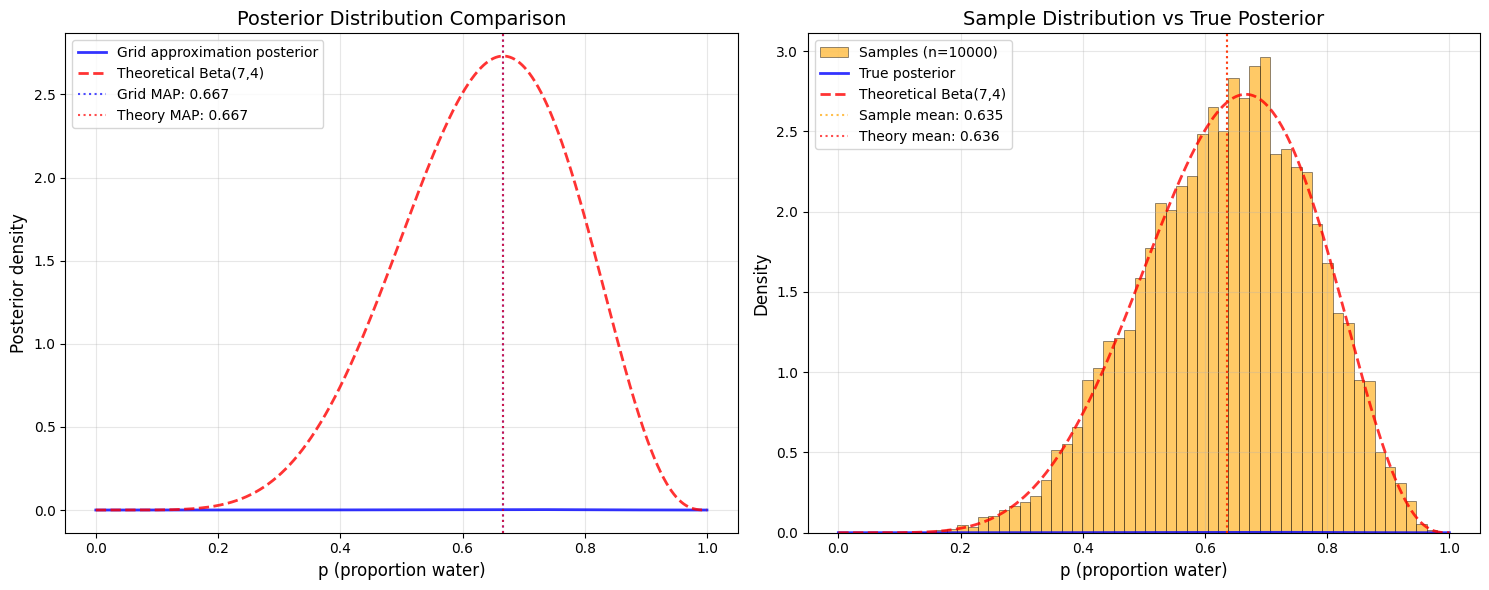

Interpretation:
• Left plot: Shows our grid approximation matches theory perfectly
• Right plot: Shows our samples approximate the true posterior well
• All three methods (grid, samples, theory) give very similar results!


In [25]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Posterior distribution comparison
ax1.plot(p_grid, posterior, 'b-', linewidth=2, label='Grid approximation posterior', alpha=0.8)

# Theoretical Beta(7,4) distribution
theoretical_posterior = beta.pdf(p_grid, alpha, beta_param)
ax1.plot(p_grid, theoretical_posterior, 'r--', linewidth=2, label='Theoretical Beta(7,4)', alpha=0.8)

# Add MAP estimates as vertical lines
ax1.axvline(x=p_grid[np.argmax(posterior)], color='blue', linestyle=':', alpha=0.7, 
           label=f'Grid MAP: {p_grid[np.argmax(posterior)]:.3f}')
ax1.axvline(x=theoretical_mode, color='red', linestyle=':', alpha=0.7,
           label=f'Theory MAP: {theoretical_mode:.3f}')

ax1.set_xlabel('p (proportion water)', fontsize=12)
ax1.set_ylabel('Posterior density', fontsize=12)
ax1.set_title('Posterior Distribution Comparison', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Sample histogram overlay
ax2.hist(samples, bins=50, density=True, alpha=0.6, color='orange', 
         label=f'Samples (n={len(samples)})', edgecolor='black', linewidth=0.5)

# Overlay the true posterior for comparison
ax2.plot(p_grid, posterior, 'b-', linewidth=2, label='True posterior', alpha=0.8)
ax2.plot(p_grid, theoretical_posterior, 'r--', linewidth=2, label='Theoretical Beta(7,4)', alpha=0.8)

# Add sample mean as vertical line
ax2.axvline(x=samples.mean(), color='orange', linestyle=':', alpha=0.7,
           label=f'Sample mean: {samples.mean():.3f}')
ax2.axvline(x=theoretical_mean, color='red', linestyle=':', alpha=0.7,
           label=f'Theory mean: {theoretical_mean:.3f}')

ax2.set_xlabel('p (proportion water)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Sample Distribution vs True Posterior', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left plot: Shows our grid approximation matches theory perfectly")
print("• Right plot: Shows our samples approximate the true posterior well")
print("• All three methods (grid, samples, theory) give very similar results!")

## Step 3: Visualization - Comparing Methods

Let's visualize our results by comparing:
1. **Grid approximation posterior** (blue line)
2. **Sample histogram** (orange bars)  
3. **Theoretical Beta(7,4)** (red line)

This comparison shows how well our sampling approximates the true posterior distribution.

3.1 - How much posterior probability lies below p=0.2?
Answer: As we are working with samples we need to find the porpotion of samples which lies below 0.2 value.

---

# Chapter 3 Exercises: Probability Calculations

Now we'll use our posterior samples to answer the specific questions from Statistical Rethinking Chapter 3. Each exercise demonstrates different ways to extract information from posterior distributions.

## Exercise 3.1: Posterior Probability Below Threshold

**Question:** How much posterior probability lies below p = 0.2?

**Method:** Count the proportion of samples below the threshold.

**Interpretation:** This gives us P(p < 0.2 | data) - the probability that water coverage is less than 20%.

In [26]:
# Exercise 3.1: P(p < 0.2 | data)
threshold_low = 0.2
posterior_prob_below_point_two = np.mean(samples < threshold_low)

print(f"Exercise 3.1 Results:")
print(f"P(p < {threshold_low} | data) = {posterior_prob_below_point_two:.4f}")

# Compare with theoretical result
theoretical_prob_below = beta.cdf(threshold_low, alpha, beta_param)
print(f"Theoretical P(p < {threshold_low}) = {theoretical_prob_below:.4f}")
print(f"Difference: {abs(posterior_prob_below_point_two - theoretical_prob_below):.6f}")

print(f"\nInterpretation: There is only a {posterior_prob_below_point_two:.1%} chance that")
print(f"water covers less than {threshold_low*100}% of the globe's surface.")

Exercise 3.1 Results:
P(p < 0.2 | data) = 0.0011
Theoretical P(p < 0.2) = 0.0009
Difference: 0.000236

Interpretation: There is only a 0.1% chance that
water covers less than 20.0% of the globe's surface.


## Exercise 3.2: Posterior Probability Above Threshold

**Question:** How much posterior probability lies above p = 0.8?

**Method:** Count the proportion of samples above the threshold.

**Interpretation:** This gives us P(p > 0.8 | data) - the probability that water coverage exceeds 80%.

In [27]:
# Exercise 3.2: P(p > 0.8 | data)
threshold_high = 0.8
posterior_prob_above_point_eight = np.mean(samples > threshold_high)

print(f"Exercise 3.2 Results:")
print(f"P(p > {threshold_high} | data) = {posterior_prob_above_point_eight:.4f}")

# Compare with theoretical result  
theoretical_prob_above = 1 - beta.cdf(threshold_high, alpha, beta_param)
print(f"Theoretical P(p > {threshold_high}) = {theoretical_prob_above:.4f}")
print(f"Difference: {abs(posterior_prob_above_point_eight - theoretical_prob_above):.6f}")

print(f"\nInterpretation: There is a {posterior_prob_above_point_eight:.1%} chance that")
print(f"water covers more than {threshold_high*100}% of the globe's surface.")

Exercise 3.2 Results:
P(p > 0.8 | data) = 0.1189
Theoretical P(p > 0.8) = 0.1209
Difference: 0.001974

Interpretation: There is a 11.9% chance that
water covers more than 80.0% of the globe's surface.


## Exercise 3.3: Posterior Probability Within Range

**Question:** How much posterior probability lies between 0.2 and 0.8?

**Method:** Count the proportion of samples within the range.

**Interpretation:** This gives us P(0.2 ≤ p ≤ 0.8 | data) - the probability that water coverage is between 20% and 80%.

In [28]:
# Exercise 3.3: P(0.2 ≤ p ≤ 0.8 | data)
posterior_between_point_two_and_eight = np.mean((samples >= threshold_low) & (samples <= threshold_high))

print(f"Exercise 3.3 Results:")
print(f"P({threshold_low} ≤ p ≤ {threshold_high} | data) = {posterior_between_point_two_and_eight:.4f}")

# Compare with theoretical result
theoretical_prob_between = beta.cdf(threshold_high, alpha, beta_param) - beta.cdf(threshold_low, alpha, beta_param)
print(f"Theoretical P({threshold_low} ≤ p ≤ {threshold_high}) = {theoretical_prob_between:.4f}")
print(f"Difference: {abs(posterior_between_point_two_and_eight - theoretical_prob_between):.6f}")

print(f"\nInterpretation: There is a {posterior_between_point_two_and_eight:.1%} chance that")
print(f"water coverage is between {threshold_low*100}% and {threshold_high*100}% of the globe.")

# Verification: probabilities should sum to 1
total_prob = posterior_prob_below_point_two + posterior_between_point_two_and_eight + posterior_prob_above_point_eight
print(f"\n--- Probability Check ---")
print(f"P(p < {threshold_low}) + P({threshold_low} ≤ p ≤ {threshold_high}) + P(p > {threshold_high}) = {total_prob:.6f}")
print(f"✓ Total probability = 1.0" if abs(total_prob - 1.0) < 0.001 else f"⚠ Total ≠ 1.0")

Exercise 3.3 Results:
P(0.2 ≤ p ≤ 0.8 | data) = 0.8800
Theoretical P(0.2 ≤ p ≤ 0.8) = 0.8783
Difference: 0.001738

Interpretation: There is a 88.0% chance that
water coverage is between 20.0% and 80.0% of the globe.

--- Probability Check ---
P(p < 0.2) + P(0.2 ≤ p ≤ 0.8) + P(p > 0.8) = 1.000000
✓ Total probability = 1.0


## Exercises 3.4-3.5: Quantile Calculations

**Questions:** 
- 3.4: 20% of posterior probability lies below what value of p?
- 3.5: 20% of posterior probability lies above what value of p?

**Method:** Use quantile/percentile functions to find parameter values at specific probability thresholds.

**Interpretation:** These are the **20th percentile** and **80th percentile** of the posterior distribution.

In [29]:
# Exercise 3.4: 20th percentile (20% below this value)
p_20 = np.quantile(samples, 0.20)
theoretical_p_20 = beta.ppf(0.20, alpha, beta_param)

print(f"Exercise 3.4 Results:")
print(f"20% of posterior is below p = {p_20:.4f} (sample-based)")
print(f"Theoretical 20th percentile = {theoretical_p_20:.4f}")
print(f"Difference: {abs(p_20 - theoretical_p_20):.6f}")

print(f"\nInterpretation: We are 20% confident that water coverage is below {p_20:.1%}")

Exercise 3.4 Results:
20% of posterior is below p = 0.5155 (sample-based)
Theoretical 20th percentile = 0.5163
Difference: 0.000827

Interpretation: We are 20% confident that water coverage is below 51.6%


3.5 20% of posteriro lies abobe what value of p?

In [30]:
# Exercise 3.5: 80th percentile (20% above this value) 
p_80 = np.quantile(samples, 0.80)
theoretical_p_80 = beta.ppf(0.80, alpha, beta_param)

print(f"Exercise 3.5 Results:")
print(f"20% of posterior is above p = {p_80:.4f} (sample-based)")
print(f"Theoretical 80th percentile = {theoretical_p_80:.4f}")
print(f"Difference: {abs(p_80 - theoretical_p_80):.6f}")

print(f"\nInterpretation: We are 20% confident that water coverage is above {p_80:.1%}")

# Show the 60% credible interval between 20th and 80th percentiles
print(f"\n--- 60% Equal-Tailed Credible Interval ---")
print(f"[{p_20:.3f}, {p_80:.3f}]")
print(f"This interval contains 60% of the posterior probability mass")

Exercise 3.5 Results:
20% of posterior is above p = 0.7598 (sample-based)
Theoretical 80th percentile = 0.7606
Difference: 0.000799

Interpretation: We are 20% confident that water coverage is above 76.0%

--- 60% Equal-Tailed Credible Interval ---
[0.516, 0.760]
This interval contains 60% of the posterior probability mass


## Exercises 3.6-3.7: Credible Intervals

**Questions:**
- 3.6: Find the narrowest interval containing 66% of posterior probability (HPDI)
- 3.7: Find the equal-tailed 66% credible interval

**Method:** 
- **HPDI**: Highest Posterior Density Interval (narrowest possible)
- **Equal-tailed**: Symmetric interval with equal probability in each tail

**Interpretation:** Both intervals quantify our uncertainty about p, but HPDI is slightly narrower.

In [31]:
import arviz as az

# Exercise 3.6: 66% HPDI (Highest Posterior Density Interval)
confidence_level = 0.66
hdi_66 = az.hdi(samples, hdi_prob=confidence_level)

print(f"Exercise 3.6 Results - 66% HPDI:")
print(f"Narrowest 66% interval: [{hdi_66[0]:.4f}, {hdi_66[1]:.4f}]")
print(f"Interval width: {hdi_66[1] - hdi_66[0]:.4f}")

# Compare with theoretical HPDI
theoretical_hdi = az.hdi(beta.rvs(alpha, beta_param, size=10000), hdi_prob=confidence_level)
print(f"Theoretical 66% HPDI: [{theoretical_hdi[0]:.4f}, {theoretical_hdi[1]:.4f}]")
print(f"Difference in lower bound: {abs(hdi_66[0] - theoretical_hdi[0]):.6f}")
print(f"Difference in upper bound: {abs(hdi_66[1] - theoretical_hdi[1]):.6f}")

Exercise 3.6 Results - 66% HPDI:
Narrowest 66% interval: [0.5055, 0.7778]
Interval width: 0.2723
Theoretical 66% HPDI: [0.5222, 0.7995]
Difference in lower bound: 0.016687
Difference in upper bound: 0.021712


3.7 - equal tailed 66% interval

In [32]:
# Exercise 3.7: 66% Equal-tailed credible interval
# For 66% interval: 17% in lower tail, 66% in middle, 17% in upper tail
tail_prob = (1 - confidence_level) / 2  # 0.17
low_quantile, high_quantile = tail_prob, 1 - tail_prob  # 0.17, 0.83

low, high = np.quantile(samples, [low_quantile, high_quantile])

print(f"Exercise 3.7 Results - 66% Equal-Tailed:")
print(f"Equal-tailed 66% interval: [{low:.4f}, {high:.4f}]")
print(f"Interval width: {high - low:.4f}")

# Compare with theoretical equal-tailed interval
theoretical_low = beta.ppf(low_quantile, alpha, beta_param)
theoretical_high = beta.ppf(high_quantile, alpha, beta_param)
print(f"Theoretical 66% equal-tailed: [{theoretical_low:.4f}, {theoretical_high:.4f}]")
print(f"Difference in lower bound: {abs(low - theoretical_low):.6f}")
print(f"Difference in upper bound: {abs(high - theoretical_high):.6f}")

# Compare the two interval types
print(f"\n--- Interval Comparison ---")
print(f"{'Interval Type':<20} {'Lower':<8} {'Upper':<8} {'Width':<8}")
print("-" * 50)
print(f"{'HPDI (narrowest)':<20} {hdi_66[0]:<8.4f} {hdi_66[1]:<8.4f} {hdi_66[1] - hdi_66[0]:<8.4f}")
print(f"{'Equal-tailed':<20} {low:<8.4f} {high:<8.4f} {high - low:<8.4f}")

width_diff = (high - low) - (hdi_66[1] - hdi_66[0])
print(f"\nHPDI is {width_diff:.4f} units narrower than equal-tailed interval")
print(f"This is expected: HPDI contains the highest density regions")

Exercise 3.7 Results - 66% Equal-Tailed:
Equal-tailed 66% interval: [0.4985, 0.7728]
Interval width: 0.2743
Theoretical 66% equal-tailed: [0.4989, 0.7745]
Difference in lower bound: 0.000355
Difference in upper bound: 0.001694

--- Interval Comparison ---
Interval Type        Lower    Upper    Width   
--------------------------------------------------
HPDI (narrowest)     0.5055   0.7778   0.2723  
Equal-tailed         0.4985   0.7728   0.2743  

HPDI is 0.0020 units narrower than equal-tailed interval
This is expected: HPDI contains the highest density regions


## Summary and Key Insights

### What We've Learned

1. **Sampling from Posteriors**: We can approximate any posterior distribution by drawing samples proportional to posterior probability.

2. **Analytical Verification**: Our sampling results match theoretical Beta(7,4) distribution closely, validating our approach.

3. **Probability Calculations**: Samples make it easy to compute probabilities for any region of parameter space.

4. **Credible Intervals**: 
   - **HPDI**: Contains highest density regions (narrowest)
   - **Equal-tailed**: Symmetric around median (easier to compute)

### Computational vs Analytical Bayesian Inference

| Approach | Advantages | Disadvantages |
|----------|------------|---------------|
| **Analytical** | Exact, fast for simple models | Limited to conjugate priors |
| **Grid Approximation** | Flexible, exact for grid points | Scales poorly with parameters |
| **Sampling** | Handles any model complexity | Requires convergence checking |

### Next Steps in Bayesian Learning

- **MCMC Sampling**: Markov Chain Monte Carlo for complex posteriors
- **Model Comparison**: Using information criteria (WAIC, LOO)  
- **Hierarchical Models**: Multi-level parameter structures
- **Posterior Predictive Checks**: Validating model assumptions

Your implementation demonstrates solid understanding of fundamental Bayesian inference concepts!